In [53]:
import pandas as pd
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
# from seaborn import heatmap
from scipy.stats import norm, ks_2samp

# Task 1

## Part 1

### 1.

#### a.

In [35]:
# G = nx.DiGraph()

# G.add_edges_from([
#     ('C', 'Q'),
#     ('W', 'Q'),
#     ('S', 'Q'),
#     ('C', 'W')
# ])

# pos = graphviz_layout(G, prog='dot')
# nx.draw_networkx(G, node_color='cyan', pos=pos)

#### b.

$$P(Q, W, S, C) \propto P(Q | W, S, C) \cdot P(W | C) \cdot P(S) \cdot P(C)$$

### 2.

<AxesSubplot: >

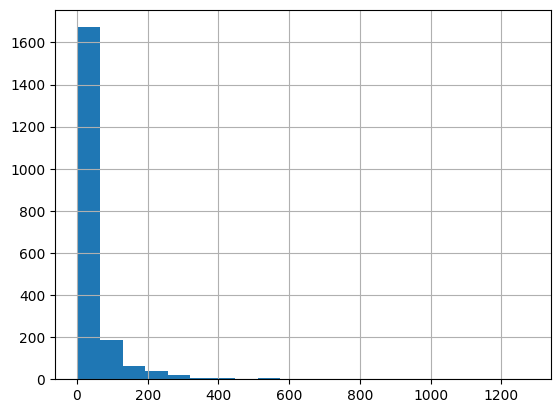

In [36]:
df_qc_train = pd.read_csv('QualityControlTraining.csv')
df_qc_train.Wait_Time.hist(bins=20)

The histogram for wait time is heavily skewed right

<AxesSubplot: >

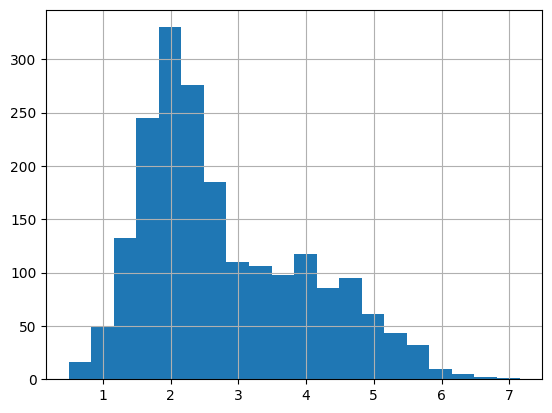

In [37]:
np.log(df_qc_train.Wait_Time).hist(bins=20)

This histogram appears to be a mixture of two gaussians, where the first is centered around 2 with small variance and the second is centered around 3.5 with larger variance.

### 3.

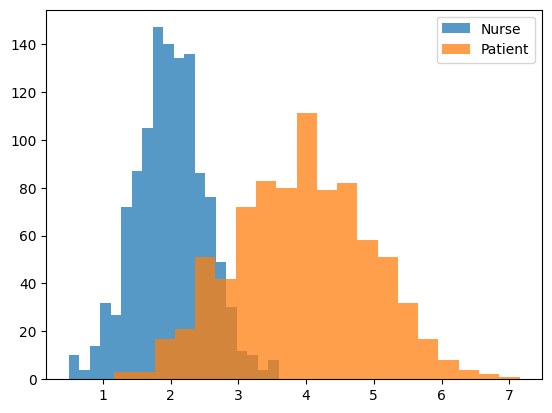

In [38]:
lg_wait_time_nurse = np.log(df_qc_train[df_qc_train.Collection_Method == 'Nurse'].Wait_Time)
lg_wait_time_patient = np.log(df_qc_train[df_qc_train.Collection_Method == 'Patient'].Wait_Time)

bins = 20
alpha = .75

plt.hist(lg_wait_time_nurse, bins=bins, alpha=alpha)
plt.hist(lg_wait_time_patient, bins=bins, alpha=alpha)
plt.legend(['Nurse', 'Patient'])

In [39]:
mean, std = lg_wait_time_nurse.mean(), lg_wait_time_nurse.std()
print(f'Nurse stats: mean = {mean:.3f}, std = {std:.3f}')

Nurse stats: mean = 1.997, std = 0.519


### 4.

#### a.

For each $C \in \{P, N\}$,
$$Q | C, W, S \sim \mathcal{N}(\mu_C(W,S), \sigma_C),$$
where
\begin{align*}
    \mu_C(w, s) &= \begin{bmatrix}1 & \log(w) & s\end{bmatrix}^\top a_C & \text{for some fixed } a_C &\in \mathbb{R}^3, \\
    \sigma_C &\in \mathbb{R} \text{ is fixed}
\end{align*}

#### b.

For all $i\in I_P$,
$$P_{\theta_P}(q_i, w_i, s_i, \text{P}) = P_{\theta_P}(q_i | w_i, s_i, \text{P}) \cdot P(w_i | \text{P}) \cdot P(s_i) \cdot P(\text{P}) $$

#### c.
For all $i \in I_P$,
\begin{align*}
P_{\theta_P}(q_i, w_i, s_i, \text{P}) &\propto_{\theta_P} P_{\theta_P}(q_i | w_i, s_i, \text{P}) \\
&\propto_{\theta_P} \frac{1}{\sigma_P} \exp\left( -\frac{1}{2\sigma_P^2} \left(q_i - \begin{bmatrix}1 & \log(w_i) & s_i\end{bmatrix}^\top a_P \right)^2 \right) \\
\Rightarrow \theta^*_P &= \underset{\sigma, a}{\arg\max} \; \sigma^{-N} \exp\left( -\frac{1}{2\sigma^2} \sum_{i\in I_P} \left(q_i - \begin{bmatrix}1 & \log(w_i) & s_i\end{bmatrix}^\top a \right)^2 \right) \\
&= \underset{\sigma, a}{\arg\min} \; N \log \sigma + \frac{1}{2\sigma^2} ||q-Z_P a||_2^2 \\
&= \underset{\sigma, a}{\arg\min} \; N \log \sigma^2 + \frac{1}{\sigma^2} ||q-Z_P a||_2^2
\end{align*}

where $Z_P \in \mathbb{R}^{N\times 3}$ is the data matrix for when the collection method is Patient, i.e. $Z_i = \begin{bmatrix} 1 & \log w_i & s_i \end{bmatrix}$ for all $i\in[I_P]$. We can break this into a sequence of two optimization problems:
\begin{align*}
    a_P^* &= \underset{a}{\arg\min}\; ||q-Z_P a||_2^2 \\
    \sigma_P^* &= \underset{\sigma}{\arg\min}\; N \log \sigma^2 + \frac{\epsilon_P^*}{\sigma^2}
\end{align*}

where $\epsilon_P^*$ be the optimal objective value associated with $a_P^*$. Notice that the first problem is just least squares, which as the closed form solution
$$a_P^* = (Z_P^T Z_P)^{-1} Z_P^T q$$
The second problem can also be solved analytically using single-variable calculus:

\begin{align*}
    \frac{\text{d}}{\text{d} \sigma} \left( N \log \sigma^2 + \frac{\epsilon}{\sigma^2} \right) &= \frac{2N}{\sigma} - \frac{2\epsilon}{\sigma^3} = 0 \\
    \Rightarrow N - \frac{\epsilon}{\sigma^2} &= 0 \\
    \Rightarrow \sigma^2 &= \frac{\epsilon}{N}
\end{align*}

Thus $(\sigma_P^*)^2 = \epsilon_P^* / N$.

In [40]:
def estimate_Q_params(c):
    df_qc_train_c = df_qc_train[df_qc_train.Collection_Method == c]
    q = df_qc_train_c.Quality_Score
    w = df_qc_train_c.Wait_Time
    s = df_qc_train_c.Storage_Temperature

    N = len(df_qc_train_c)

    Z = np.stack(
        [np.ones(N), np.log(w), s], 
        axis=1
    )

    a = np.linalg.solve(Z.T @ Z, Z.T @ q)
    b = q - Z@a
    eps = b@b
    sigma_sq = eps / N

    return sigma_sq, a


q = df_qc_train.Quality_Score
w = df_qc_train.Wait_Time
s = df_qc_train.Storage_Temperature

sigma_sq, a = estimate_Q_params('Patient')

var_print = f'{sigma_sq:.3f}'
a_print = [f'{x:.3f}' for x in a]

print('estimated parameters:')
print('var =', var_print)
print(f'a =', a_print)

estimated parameters:
var = 4.055
a = ['-9.092', '-1.916', '-2.066']


#### d.

In [41]:
df_qc_train_patient = df_qc_train[df_qc_train.Collection_Method == 'Patient'].copy()
df_qc_train_patient['Lg_Wait_Time'] = np.log(df_qc_train_patient.Wait_Time)
lg_wait_time_mean = df_qc_train_patient.Lg_Wait_Time.mean()
storage_time_mean = df_qc_train_patient.Storage_Temperature.mean()

wait_time_mask = df_qc_train_patient.Lg_Wait_Time.between(lg_wait_time_mean - 0.05, lg_wait_time_mean + 0.05)
storage_time_mask = df_qc_train_patient.Storage_Temperature.between(storage_time_mean - 0.05, storage_time_mean + 0.05)

sigma = df_qc_train_patient[wait_time_mask & storage_time_mask].Quality_Score.std()
print(f'var = {sigma ** 2:.3f}')

var = 4.685


This variance is close to what we computed in part c, with an error of about $\frac{4.685 - 4.055}{4.055} = 15.536\%$

### 5.

\begin{align*}
    \underset{C}{\arg \max}\; P(C | W, S, Q) &= \underset{C}{\arg \max}\; P(C, W, S, Q) \\
    &= \underset{C}{\arg \max}\; P(Q | W, S, C) \cdot P(W | C) \cdot P(C)
\end{align*}

In [42]:
# estimate parameters for each class
param_estimates = {}
for c in ['Patient', 'Nurse']:
    param_estimates[c] = {}
    df_qc_train_c = df_qc_train[df_qc_train.Collection_Method == c]

    param_estimates[c]['prior'] = len(df_qc_train_c) / len(df_qc_train)

    Q_sigma_sq, Q_a = estimate_Q_params(c)
    param_estimates[c]['Q_a'] = Q_a
    param_estimates[c]['Q_sigma_sq'] = Q_sigma_sq

    lg_W = np.log(df_qc_train_c.Wait_Time)
    param_estimates[c]['lgW_mu'] = lg_W.mean()
    param_estimates[c]['lgW_sigma'] = lg_W.std()



def pdf_Q(q, w, s, c):
    '''q, w, s, are columns from the df; c is a fixed class;
    computes densities of q | w, s, c for each row; vectorized
    '''
    Z = np.stack(
        [np.ones(len(q)), np.log(w), s], 
        axis=1
    )
    sigma_sq = param_estimates[c]['Q_sigma_sq']
    a = param_estimates[c]['Q_a']
    b = q - Z@a
    return np.exp(-b*b / (2*sigma_sq)) / np.sqrt(sigma_sq)



def compute_scores(q, w, s, c):
    '''q, w, s, are columns from the df; c is a fixed class;
    computes MAP scores for each row assuming class c; vecotrized
    '''
    Q_density = pdf_Q(q, w, s, c)

    W_mu = param_estimates[c]['lgW_mu']
    W_sigma = param_estimates[c]['lgW_sigma']
    W_density = norm(loc=W_mu, scale=W_sigma).pdf(np.log(w))

    prior = param_estimates[c]['prior']

    return Q_density * W_density * prior

In [43]:
q = df_qc_train.Quality_Score
w = df_qc_train.Wait_Time
s = df_qc_train.Storage_Temperature

patient_scores = compute_scores(q, w, s, 'Patient')
nurse_scores = compute_scores(q, w, s, 'Nurse')

# for each row, prediction is class with higher score
df_qc_predict = df_qc_train.copy()
df_qc_predict['Prediction'] = (patient_scores > nurse_scores)
df_qc_predict.Prediction.replace({True: 'Patient', False: 'Nurse'}, inplace=True)

# rows where prediction is incorrect
df_qc_predict[df_qc_predict.Collection_Method != df_qc_predict.Prediction]

,Collection_Method,Wait_Time,Storage_Temperature,Quality_Score,Prediction
447,Patient,67.721012,-9.491731,10.405145,Nurse
1372,Patient,9.676858,-8.666114,9.787584,Nurse
1566,Patient,30.885939,-10.357828,11.130817,Nurse
1779,Patient,49.562768,-8.989160,9.229951,Nurse
1801,Patient,9.447169,-9.905472,10.931693,Nurse


In [44]:
first_row = df_qc_train.iloc[0]
print(first_row, '\n')

c,w,s,q = first_row
w = np.array([w])
s = np.array([s])
q = np.array([q])

patient_score = compute_scores(q, w, s, 'Patient')
nurse_score = compute_scores(q, w, s, 'Nurse')

print(f'patient score: {patient_score.item():.5f}')
print(f'nurse score: {nurse_score.item():.5f}')
print()

print('since nurse score > patient score, we predict that this sample was collected by a nurse (which happens to be correct).')

Collection_Method          Nurse
Wait_Time               4.763624
Storage_Temperature    -10.82688
Quality_Score          14.979513
Name: 0, dtype: object 

patient score: 0.00030
nurse score: 0.60541

since nurse score > patient score, we predict that this sample was collected by a nurse (which happens to be correct).


### 6.

In [45]:
df_qc = pd.read_csv('QualityControl.csv').drop('Unnamed: 0', axis=1)

def p_val(row):
    c, w, s, = row

    a = param_estimates[c]['Q_a']
    sigma_sq = param_estimates[c]['Q_sigma_sq']

    mu = a @ np.array([1, np.log(w), s])
    std = np.sqrt(sigma_sq)
    return norm(loc=mu, scale=std).cdf(0)

p_vals = df_qc.apply(p_val, axis=1)
df_qc_poor = df_qc[p_vals > .05].copy()
df_qc_poor['p_val'] = p_vals

print('poor quality samples:')
df_qc_poor

poor quality samples:


,Collection_Method,Wait_Time,Storage_Temperature,p_val
9,Patient,67.213921,-9.108656,0.204365
45,Patient,359.243754,-9.270181,0.726693
147,Patient,144.947799,-9.069125,0.478301
151,Patient,62.146447,-9.290589,0.138439
199,Patient,115.896734,-9.962477,0.118257
211,Patient,110.402176,-9.945948,0.112566
223,Patient,73.460547,-8.959942,0.277928
229,Patient,20.716883,-8.147960,0.168460
278,Patient,117.148010,-8.825812,0.497054
346,Patient,33.120764,-8.407036,0.217799


In [46]:
# first_row = df_qc.iloc[0]
# print(first_row, '\n')

# a = param_estimates[c]['Q_a']
# var = param_estimates[c]['Q_sigma_sq']

# a_print = [f'{x:.3f}' for x in a]
# var_print = f'{var:.3f}'

# print('Q|C,W,S parameters:')
# print(f'a =', a_print)
# print('var =', var_print)
# print()

# mu = a @ np.array([1, np.log(w), s])
# std = np.sqrt(sigma_sq)
# print('Q|C,W,S mean and std:')
# print(f'mu = {mu:.3f}')
# print(f'std = {std:.3f}')
# print()

# p_val = norm(loc=mu, scale=std).cdf(0)
# print(f'P(Q < 0 | C,W,S) = {p_val:.3f}')

In [47]:
df_qc_good = df_qc[p_vals < .05]
df_qc_good

,Collection_Method,Wait_Time,Storage_Temperature
0,Patient,70.023933,-10.570253
1,Nurse,3.148633,-8.892279
2,Nurse,10.057289,-11.114723
3,Nurse,13.124937,-10.623559
4,Nurse,5.276018,-8.769540
...,...,...,...
395,Patient,31.725869,-11.327799
396,Nurse,4.722072,-10.423691
397,Patient,32.629223,-10.003274
398,Nurse,13.076011,-11.057704


## Part 2

In [48]:
df_abundance = pd.read_csv('MicrobeAbundance.csv').drop('Unnamed: 0', axis=1)
df_abundance.head()

,Microbe_0,Microbe_1,Microbe_2,Microbe_3,Microbe_4,Microbe_5,Microbe_6,Microbe_7,Microbe_8,Microbe_9,...,Microbe_111,Microbe_112,Microbe_113,Microbe_114,Microbe_115,Microbe_116,Microbe_117,Microbe_118,Microbe_119,Group
0,54,50,49,79,50,77,59,46,81,52,...,82,47,51,63,57,54,82,53,78,control
1,59,62,65,56,62,59,62,62,58,57,...,58,66,49,30,48,62,57,64,64,control
2,67,67,69,53,66,57,66,71,58,41,...,56,70,48,70,38,41,52,67,63,control
3,57,67,66,51,68,54,60,64,51,37,...,54,65,41,25,41,35,54,63,49,control
4,76,56,57,40,55,43,53,53,38,42,...,39,58,53,73,46,43,43,48,39,control


In [49]:
# fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(30,30))

# min = df_abundance.drop('Group', axis=1).min().min()
# max = df_abundance.drop('Group', axis=1).max().max()

# heatmap(df_abundance[df_abundance.Group == 'control'].drop('Group', axis=1), ax=ax[0], vmin=min, vmax=max)
# heatmap(df_abundance[df_abundance.Group == 'case'].drop('Group', axis=1), ax=ax[1], vmin=min, vmax=max)

# ax[0].title.set_text('control')
# ax[1].title.set_text('case')


some of the columns are noticably darker in the "case" heatmap than in the "control" heatmap which suggests that "case" subjects are lacking in those microbes compared to "control" subjects.

# Task 2

## Part 1

### 1.

#### a.

The KS test is a non-parametric test. Non-parametric tests are used for variables with continuous distributions.

In [97]:

def ks_sample(col):
    cases = col[df_case_mask]
    control = col[df_control_mask]
    return ks_2samp(control, cases)[1]

df_microbes = df_abundance.drop('Group', axis=1)
df_case_mask = df_abundance.Group == 'case'
df_control_mask = df_abundance.Group == 'control'

microbes_p_vals = df_microbes.apply(ks_sample, axis=0)
microbes_p_vals


Microbe_0      3.009847e-03
Microbe_1      8.655265e-01
Microbe_2      7.125821e-01
Microbe_3      2.205412e-01
Microbe_4      3.281154e-01
                   ...     
Microbe_115    3.133095e-21
Microbe_116    1.298543e-18
Microbe_117    1.779335e-01
Microbe_118    9.646522e-01
Microbe_119    9.238374e-01
Length: 120, dtype: float64

In [99]:
idx = 1
microbe_zero_pval = microbes_p_vals[idx]
print(f"Microbe_{idx}: {microbe_zero_pval:.3f}")

Microbe_1: 0.866


The null hypothesis states that the control group and the cases group have the same distribution. Using the 2 sample KS test for Microbe_1, we find it statistically significant (and is declared 'altered') and that the distributions must be the same according to the null hypothesis. 

In [113]:
alphas = [0.1, 0.05, 0.01, 0.005, 0.001]

df_alphas = pd.DataFrame(index=alphas, columns=['count'])

for alpha in alphas:
    df_alphas.loc[alpha, 'count'] = (microbes_p_vals > alpha).sum()
    
df_alphas

,count
0.100,81
0.050,88
0.010,93
0.005,96
0.001,99
